# Hecatomb viral analysis

This is an analysis of the viral data from the CF MGI sequence libraries. We are exploring different viral components.

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.api as sms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Read the data

In [2]:
metadata = pd.read_csv('CF_Metadata_Table-2023-03-23.tsv.gz',compression='gzip',header=0,sep='\t')
vmr = pd.read_csv('VMR_MSL39_v1.ascii.tsv.gz', compression='gzip',header=0,sep='\t')

In this analysis, I am _only_ using `aa` hits, because the `nt` hits are often spurious and I'm skeptical about them.

We just filter out `aa` hits, and start by looking at different viral families that are found in our samples.

In [3]:
# the blacklist is some dodgy sequences that we need to filter out.
blacklist = ['A0A097ZRK1', 'G0W2I5']

In [4]:
data = pd.read_csv('bigtable.tsv.gz',compression='gzip',header=0,sep='\t')

In [5]:
# choose only the amino acid sequences
virusesFiltered = data[(data.alnType == "aa") & (data.kingdom == "Viruses") & (~data.targetID.isin(blacklist) & (data.evalue < 1e-20))]

In [6]:
# create new columns for the patient and the sample date
virusesFiltered[['patient', 'date', 'Sputum or BAL']] = virusesFiltered['sampleID'].str.split('_', expand=True)

/local/edwa0468/2368994/ipykernel_2954723/330175779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  virusesFiltered[['patient', 'date', 'Sputum or BAL']] = virusesFiltered['sampleID'].str.split('_', expand=True)
/local/edwa0468/2368994/ipykernel_2954723/330175779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  virusesFiltered[['patient', 'date', 'Sputum or BAL']] = virusesFiltered['sampleID'].str.split('_', expand=True)
/local/edwa0468/2368994/ipykernel_2954723/330175779.py:2: SettingWithCopyWarning

### Add the domain and then filter the viruses for now!

This data comes from the [VMR](https://ictv.global/vmr) so its not that great! The `host source` could be a host or it could be a source, or it could be both!

We end up with:
    'bacteria', 'algae', 'vertebrates', 'protists', 'archaea',
    'invertebrates', 'plants', 'fungi', 'invertebrates, vertebrates',
    'plants (S)'

The `plants (S)` means the sample was taken from a plant.

In [7]:
virusesFiltHost = pd.merge(virusesFiltered, vmr[['Family', 'Host source']], left_on="family", right_on="Family", how='left')
really_bacterial = ['unclassified Caudoviricetes family', 'unclassified Crassvirales family']
virusesFiltHost.loc[(virusesFiltHost['family'].isin(really_bacterial)), 'Host source'] = 'bacteria'
to_remove = []

#### A quick look at some of these families

#### Bacteria

There are plenty of bacterial viruses (duh!) so we make that its own dataframe and filter them out from virusesFiltered

In [8]:
bacterial_viruses = virusesFiltHost[(virusesFiltHost['Host source'] == 'bacteria')]
to_remove.append('bacteria')

#### Archaea

In [9]:
host_source = "archaea"
rds = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].shape[0]
sps = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].species.unique()
fams = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].family.unique()
print(f"There are {rds} reads that map to {host_source} viruses, and they belong to {len(sps)} species ", end="")
if len(sps) < 5:
    spsstr = "; ".join(sps)
    print(f"({spsstr}) ", end="")
print(f"and {len(fams)} families: {fams}")
to_remove.append(host_source)

There are 24 reads that map to archaea viruses, and they belong to 5 species and 4 families: ['Saparoviridae' 'Anaerodiviridae' 'Hafunaviridae' 'Shortaselviridae']


#### Plants

There are not really enough plant related sequences (there are 736 total) to make any meaningful comparisons, so we will ignore those.

In [10]:
host_source = "plants"
rds = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].shape[0]
sps = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].species.unique()
fams = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].family.unique()
print(f"There are {rds} reads that map to {host_source} viruses, and they belong to {len(sps)} species ", end="")
if len(sps) < 5:
    spsstr = "; ".join(sps)
    print(f"({spsstr}) ", end="")
print(f"and {len(fams)} families: {fams}")
to_remove.append(host_source)

There are 420 reads that map to plants viruses, and they belong to 1 species (Rice tungro bacilliform virus) and 1 families: ['Caulimoviridae']


In [11]:
host_source = "plants (S)"
rds = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].shape[0]
sps = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].species.unique()
fams = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].family.unique()
print(f"There are {rds} reads that map to {host_source} viruses, and they belong to {len(sps)} species ", end="")
if len(sps) < 5:
    spsstr = "; ".join(sps)
    print(f"({spsstr}) ", end="")
print(f"and {len(fams)} families: {fams}")
to_remove.append(host_source)

There are 0 reads that map to plants (S) viruses, and they belong to 0 species () and 0 families: []


#### Algae

There are quite a few algal viruses but they are all members of the Phycodnaviridae.

In [12]:
host_source = "algae"
rds = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].shape[0]
sps = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].species.unique()
fams = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].family.unique()
print(f"There are {rds} reads that map to {host_source} viruses, and they belong to {len(sps)} species ", end="")
if len(sps) < 5:
    spsstr = "; ".join(sps)
    print(f"({spsstr}) ", end="")
print(f"and {len(fams)} families: {fams}")
to_remove.append(host_source)

There are 140 reads that map to algae viruses, and they belong to 6 species and 1 families: ['Phycodnaviridae']


#### Protists

In [13]:
host_source = "protists"
rds = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].shape[0]
sps = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].species.unique()
fams = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].family.unique()
print(f"There are {rds} reads that map to {host_source} viruses, and they belong to {len(sps)} species ", end="")
if len(sps) < 5:
    spsstr = "; ".join(sps)
    print(f"({spsstr}) ", end="")
print(f"and {len(fams)} families: {fams}")

There are 195 reads that map to protists viruses, and they belong to 9 species and 3 families: ['Pithoviridae' 'Mimiviridae' 'Marseilleviridae']


I'm not sure about these. I have included them for now, because somne of those families (Metaviridae) include LTR retrotransposons from Eukaryotes.

#### Invertebrates

In [14]:
host_source = "invertebrates"
rds = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].shape[0]
sps = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].species.unique()
fams = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].family.unique()
print(f"There are {rds} reads that map to {host_source} viruses, and they belong to {len(sps)} species ", end="")
if len(sps) < 5:
    spsstr = "; ".join(sps)
    print(f"({spsstr}) ", end="")
print(f"and {len(fams)} families: {fams}")

There are 94 reads that map to invertebrates viruses, and they belong to 7 species and 4 families: ['Poxviridae' 'Anelloviridae' 'Parvoviridae' 'Nimaviridae']


I don't think we should remove these - I think they may also infect euks

#### Fungi

In [15]:
host_source = "fungi"
rds = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].shape[0]
sps = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].species.unique()
fams = virusesFiltHost[(virusesFiltHost['Host source'] == host_source)].family.unique()
print(f"There are {rds} reads that map to {host_source} viruses, and they belong to {len(sps)} species ", end="")
if len(sps) < 5:
    spsstr = "; ".join(sps)
    print(f"({spsstr}) ", end="")
print(f"and {len(fams)} families: {fams}")

There are 0 reads that map to fungi viruses, and they belong to 0 species () and 0 families: []


Hmm, odd that the metaviridae are represented here too, since I did the join on viral family. Ho hum, we'll keep these, too.

### Filter out the unwanted viruses

In [16]:
virusesFiltHost = virusesFiltHost[~virusesFiltHost['Host source'].isin(to_remove)]
virusesFiltHost['Host source'].unique()

array([nan, 'vertebrates', 'protists', 'invertebrates',
       'invertebrates, vertebrates'], dtype=object)

### What do we have after filtering?

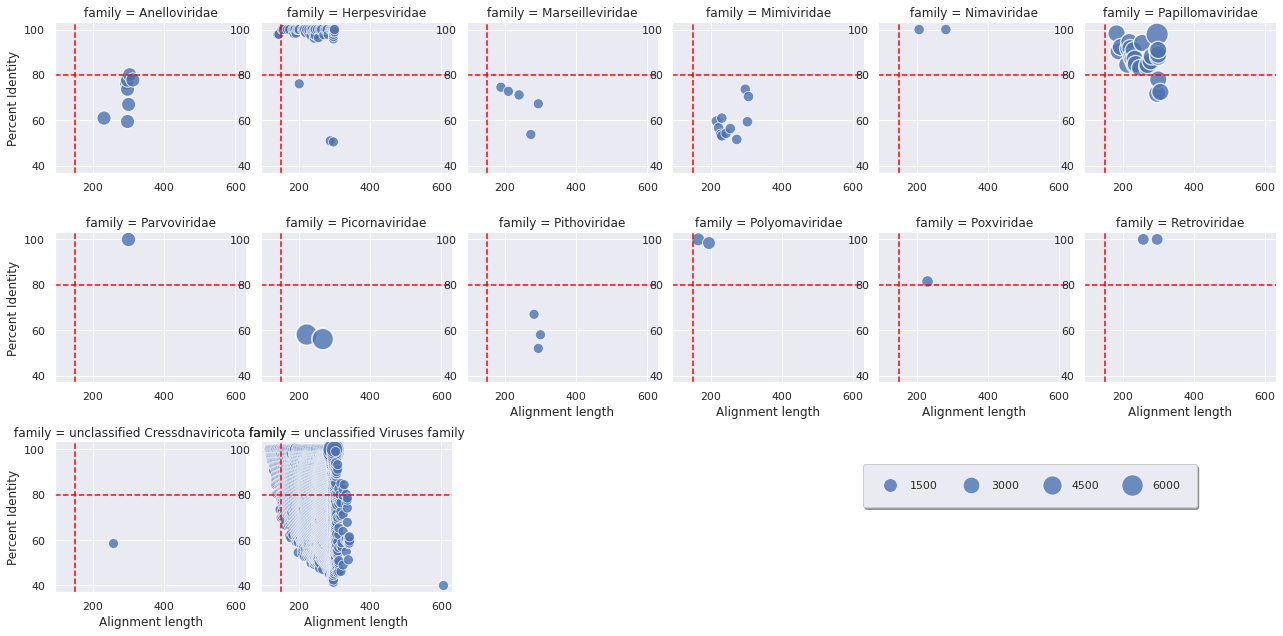

In [45]:
#filter
virusesGroup = virusesFiltHost.groupby(by=['family','alnlen','pident'], as_index=False).count()

#styling
sizeScatter = 10 * virusesGroup['count']
sns.set_style("darkgrid")
sns.set_palette("colorblind")
sns.set(rc={'figure.figsize':(20,10)})

g = sns.FacetGrid(virusesGroup, col="family", col_wrap=6)
g.map_dataframe(sns.scatterplot, "alnlen", "pident", alpha=.8, sizes=(100,500), size=sizeScatter)
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelleft=True, labelbottom=True)
    ax.axhline(y=80, c='red', linestyle='dashed', label="_horizontal")
    ax.axvline(x=150, c='red', linestyle='dashed', label="_vertical")

g.fig.subplots_adjust(hspace=0.4)
g.set_axis_labels("Alignment length", "Percent Identity")
plt.legend(bbox_to_anchor=(5.0,1), loc=0, borderaxespad=2,ncol=6, shadow=True, labelspacing=1.5, borderpad=1.5)
plt.savefig("img/EukViruses.png")
plt.show()


In [18]:
virusesFiltHost.family.unique()

array(['unclassified Viruses family', 'Papillomaviridae', 'Pithoviridae',
       'Mimiviridae', 'Herpesviridae', 'Retroviridae', 'Poxviridae',
       'Anelloviridae', 'unclassified Cressdnaviricota family',
       'Parvoviridae', 'Marseilleviridae', 'Nimaviridae',
       'Picornaviridae', 'Polyomaviridae'], dtype=object)

### Retroviridae

There are lots of hits to Lentivirus, especially HIV-1, which we know are spurious. Here, we filter those out. These are hits to `G0W2I5` and `A0A097ZRK1`. (Note, I am keeping a list of sequences that are incorrect in `sequence_ids.yaml` and those are included in the `blacklist` list above. Here we just look at other Retroviridae.

We note that these are hERVs and we only find them in a few samples, as we might expect.

In [19]:
virusesFiltHost[virusesFiltHost.family == 'Retroviridae']

,seqID,sampleID,count,percent,alnType,targetID,evalue,pident,fident,nident,...,family,genus,species,baltimoreType,baltimoreGroup,patient,date,Sputum or BAL,Family,Host source
18669,1690154_20180406_S:1:1.679e-04:47862,1690154_20180406_S,1,0.000168,aa,P03355,1.540000e-48,100.0,1.0,86,...,Retroviridae,Gammaretrovirus,Murine leukemia virus,ssRNA-RT,VI,1690154,20180406,S,Retroviridae,vertebrates
18670,1690154_20180406_S:1:1.679e-04:47862,1690154_20180406_S,1,0.000168,aa,P03355,1.540000e-48,100.0,1.0,86,...,Retroviridae,Gammaretrovirus,Murine leukemia virus,ssRNA-RT,VI,1690154,20180406,S,Retroviridae,vertebrates
18671,1690154_20180406_S:1:1.679e-04:47862,1690154_20180406_S,1,0.000168,aa,P03355,1.540000e-48,100.0,1.0,86,...,Retroviridae,Gammaretrovirus,Murine leukemia virus,ssRNA-RT,VI,1690154,20180406,S,Retroviridae,vertebrates
18672,1690154_20180406_S:1:1.679e-04:47862,1690154_20180406_S,1,0.000168,aa,P03355,1.540000e-48,100.0,1.0,86,...,Retroviridae,Gammaretrovirus,Murine leukemia virus,ssRNA-RT,VI,1690154,20180406,S,Retroviridae,vertebrates
18673,1690154_20180406_S:1:1.679e-04:47862,1690154_20180406_S,1,0.000168,aa,P03355,1.540000e-48,100.0,1.0,86,...,Retroviridae,Gammaretrovirus,Murine leukemia virus,ssRNA-RT,VI,1690154,20180406,S,Retroviridae,vertebrates
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331330,877469_20190115_S:1:2.298e-03:1657,877469_20190115_S,1,0.002298,aa,P03355,2.198000e-59,100.0,1.0,99,...,Retroviridae,Gammaretrovirus,Murine leukemia virus,ssRNA-RT,VI,877469,20190115,S,Retroviridae,vertebrates
331331,877469_20190115_S:1:2.298e-03:1657,877469_20190115_S,1,0.002298,aa,P03355,2.198000e-59,100.0,1.0,99,...,Retroviridae,Gammaretrovirus,Murine leukemia virus,ssRNA-RT,VI,877469,20190115,S,Retroviridae,vertebrates
331332,877469_20190115_S:1:2.298e-03:1657,877469_20190115_S,1,0.002298,aa,P03355,2.198000e-59,100.0,1.0,99,...,Retroviridae,Gammaretrovirus,Murine leukemia virus,ssRNA-RT,VI,877469,20190115,S,Retroviridae,vertebrates
331333,877469_20190115_S:1:2.298e-03:1657,877469_20190115_S,1,0.002298,aa,P03355,2.198000e-59,100.0,1.0,99,...,Retroviridae,Gammaretrovirus,Murine leukemia virus,ssRNA-RT,VI,877469,20190115,S,Retroviridae,vertebrates


In [20]:
virusesFiltHost[virusesFiltHost.family == 'Retroviridae'].patient.unique()

array(['1690154', '877469'], dtype=object)

### Poxviridae

In [21]:
virusesFiltHost[virusesFiltHost.family == 'Poxviridae'].head()

,seqID,sampleID,count,percent,alnType,targetID,evalue,pident,fident,nident,...,family,genus,species,baltimoreType,baltimoreGroup,patient,date,Sputum or BAL,Family,Host source
21657,634207_20180517_S:1:1.612e-04:109045,634207_20180517_S,1,0.000161,aa,F1AXJ9,1.794000e-35,81.5,0.815,62,...,Poxviridae,Parapoxvirus,Orf virus,dsDNA,I,634207,20180517,S,Poxviridae,vertebrates
21658,634207_20180517_S:1:1.612e-04:109045,634207_20180517_S,1,0.000161,aa,F1AXJ9,1.794000e-35,81.5,0.815,62,...,Poxviridae,Parapoxvirus,Orf virus,dsDNA,I,634207,20180517,S,Poxviridae,vertebrates
21659,634207_20180517_S:1:1.612e-04:109045,634207_20180517_S,1,0.000161,aa,F1AXJ9,1.794000e-35,81.5,0.815,62,...,Poxviridae,Parapoxvirus,Orf virus,dsDNA,I,634207,20180517,S,Poxviridae,vertebrates
21660,634207_20180517_S:1:1.612e-04:109045,634207_20180517_S,1,0.000161,aa,F1AXJ9,1.794000e-35,81.5,0.815,62,...,Poxviridae,Parapoxvirus,Orf virus,dsDNA,I,634207,20180517,S,Poxviridae,vertebrates
21661,634207_20180517_S:1:1.612e-04:109045,634207_20180517_S,1,0.000161,aa,F1AXJ9,1.794000e-35,81.5,0.815,62,...,Poxviridae,Parapoxvirus,Orf virus,dsDNA,I,634207,20180517,S,Poxviridae,vertebrates


In [22]:
virusesFiltHost[virusesFiltHost.family == 'Poxviridae'].targetID.unique()

array(['F1AXJ9'], dtype=object)

In [23]:
virusesFiltHost[virusesFiltHost.family == 'Poxviridae'].patient.unique()

array(['634207'], dtype=object)

### Parvoviridae

In [24]:
virusesFiltHost[virusesFiltHost.family == 'Parvoviridae'].targetID.unique()

array(['S5YSH5'], dtype=object)

In [25]:
virusesFiltHost[virusesFiltHost.family == 'Parvoviridae'].patient.unique()

array(['788707'], dtype=object)

### Nimaviridae

In [26]:
virusesFiltHost[virusesFiltHost.family == 'Nimaviridae']

,seqID,sampleID,count,percent,alnType,targetID,evalue,pident,fident,nident,...,family,genus,species,baltimoreType,baltimoreGroup,patient,date,Sputum or BAL,Family,Host source
157913,1565754_20171128_S:1:2.983e-04:45161,1565754_20171128_S,1,0.000298,aa,Q8QTC0,1.201000e-55,100.0,1.0,94,...,Nimaviridae,Whispovirus,White spot syndrome virus,dsDNA,I,1565754,20171128,S,Nimaviridae,invertebrates
157914,1565754_20171128_S:1:2.983e-04:45161,1565754_20171128_S,1,0.000298,aa,Q8QTC0,1.201000e-55,100.0,1.0,94,...,Nimaviridae,Whispovirus,White spot syndrome virus,dsDNA,I,1565754,20171128,S,Nimaviridae,invertebrates
157915,1565754_20171128_S:1:2.983e-04:45161,1565754_20171128_S,1,0.000298,aa,Q8QTC0,1.201000e-55,100.0,1.0,94,...,Nimaviridae,Whispovirus,White spot syndrome virus,dsDNA,I,1565754,20171128,S,Nimaviridae,invertebrates
157916,1565754_20171128_S:1:2.983e-04:45161,1565754_20171128_S,1,0.000298,aa,Q8QTC0,1.201000e-55,100.0,1.0,94,...,Nimaviridae,Whispovirus,White spot syndrome virus,dsDNA,I,1565754,20171128,S,Nimaviridae,invertebrates
157917,1565754_20171128_S:1:2.983e-04:45161,1565754_20171128_S,1,0.000298,aa,Q8QTC0,1.201000e-55,100.0,1.0,94,...,Nimaviridae,Whispovirus,White spot syndrome virus,dsDNA,I,1565754,20171128,S,Nimaviridae,invertebrates
157918,1565754_20171128_S:1:2.983e-04:45161,1565754_20171128_S,1,0.000298,aa,Q8QTC0,1.201000e-55,100.0,1.0,94,...,Nimaviridae,Whispovirus,White spot syndrome virus,dsDNA,I,1565754,20171128,S,Nimaviridae,invertebrates
157919,1565754_20171128_S:1:2.983e-04:45161,1565754_20171128_S,1,0.000298,aa,Q8QTC0,1.201000e-55,100.0,1.0,94,...,Nimaviridae,Whispovirus,White spot syndrome virus,dsDNA,I,1565754,20171128,S,Nimaviridae,invertebrates
157920,1565754_20171128_S:1:2.983e-04:45161,1565754_20171128_S,1,0.000298,aa,Q8QTC0,1.201000e-55,100.0,1.0,94,...,Nimaviridae,Whispovirus,White spot syndrome virus,dsDNA,I,1565754,20171128,S,Nimaviridae,invertebrates
157921,1565754_20171128_S:1:2.983e-04:45161,1565754_20171128_S,1,0.000298,aa,Q8QTC0,1.201000e-55,100.0,1.0,94,...,Nimaviridae,Whispovirus,White spot syndrome virus,dsDNA,I,1565754,20171128,S,Nimaviridae,invertebrates
157922,1565754_20171128_S:1:2.983e-04:45161,1565754_20171128_S,1,0.000298,aa,Q8QTC0,1.201000e-55,100.0,1.0,94,...,Nimaviridae,Whispovirus,White spot syndrome virus,dsDNA,I,1565754,20171128,S,Nimaviridae,invertebrates


In [27]:
virusesFiltHost[virusesFiltHost.family == 'Nimaviridae'].targetID.unique()

array(['Q8QTC0'], dtype=object)

In [28]:
virusesFiltHost[virusesFiltHost.family == 'Nimaviridae'].patient.unique()

array(['1565754', '1316979'], dtype=object)

#### Adenoviridae

In [29]:
data[data.family == 'Adenoviridae'].alnType.unique()

array(['nt'], dtype=object)

all the hits to Adenoviruses are nt hits and there are no aa hits. This seems wrong!

### Herpes viruses

Who has them and what do they have?

In [30]:

witherpes = virusesFiltHost[virusesFiltHost.family == 'Herpesviridae'].patient.unique().shape[0]
herpessamps = virusesFiltHost[virusesFiltHost.family == 'Herpesviridae'].sampleID.unique().shape[0]

totalp = virusesFiltHost.patient.unique().shape[0]
print(f"{herpessamps} samples from {witherpes} pwCF out of {totalp} pwCF have Herpes viruses. Remember, some samples will appear multiple times because they are different matches to the herpes virus genome!")

17 samples from 17 pwCF out of 68 pwCF have Herpes viruses. Remember, some samples will appear multiple times because they are different matches to the herpes virus genome!


In [31]:
herpes = virusesFiltHost[virusesFiltHost.family == 'Herpesviridae']

In [32]:
herpes.species

15872      Human betaherpesvirus 6
23941      Human betaherpesvirus 7
27281     Human gammaherpesvirus 4
28359     Human gammaherpesvirus 4
40458      Human betaherpesvirus 7
                    ...           
442190    Human gammaherpesvirus 4
449682     Human betaherpesvirus 7
449724     Human betaherpesvirus 7
451518    Human betaherpesvirus 6B
454179    Human gammaherpesvirus 4
Name: species, Length: 92, dtype: object

In [33]:
herpes.loc[:, 'renamed_species'] = herpes.species
herpes.loc[:,'renamed_species'] = herpes['renamed_species'].apply(lambda x: ' '.join(x.split(' ')[1:] if 'unclassified' not in x else x.split(' ')))
herpes['renamed_species']

/local/edwa0468/2368994/ipykernel_2954723/648641319.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  herpes.loc[:, 'renamed_species'] = herpes.species


15872      betaherpesvirus 6
23941      betaherpesvirus 7
27281     gammaherpesvirus 4
28359     gammaherpesvirus 4
40458      betaherpesvirus 7
                 ...        
442190    gammaherpesvirus 4
449682     betaherpesvirus 7
449724     betaherpesvirus 7
451518    betaherpesvirus 6B
454179    gammaherpesvirus 4
Name: renamed_species, Length: 92, dtype: object

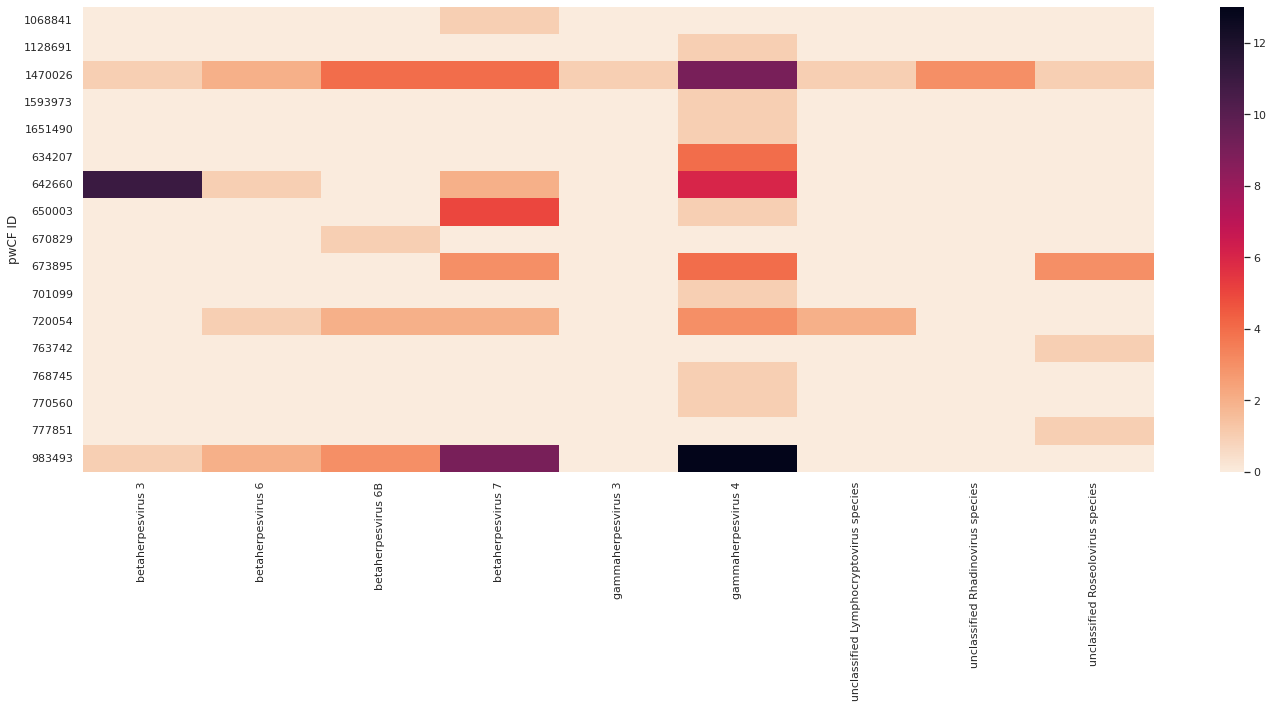

In [46]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(20,10)})
sns.heatmap(pd.crosstab([herpes.patient], [sorted(herpes.renamed_species)], values=herpes['count'], aggfunc='sum', dropna=False).fillna(0),
            cmap="rocket_r")
plt.xlabel("")
plt.ylabel("pwCF ID")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("img/HerpesViruses.png")
plt.show()

### hERV data

What are the hERVs and who has them!

It turns out only six samples have hERV data, and these are all single reads. So they are there, but are they important for this study?

In [35]:
virusesFiltHost[virusesFiltHost.family == 'Retroviridae']

,seqID,sampleID,count,percent,alnType,targetID,evalue,pident,fident,nident,...,family,genus,species,baltimoreType,baltimoreGroup,patient,date,Sputum or BAL,Family,Host source
18669,1690154_20180406_S:1:1.679e-04:47862,1690154_20180406_S,1,0.000168,aa,P03355,1.540000e-48,100.0,1.0,86,...,Retroviridae,Gammaretrovirus,Murine leukemia virus,ssRNA-RT,VI,1690154,20180406,S,Retroviridae,vertebrates
18670,1690154_20180406_S:1:1.679e-04:47862,1690154_20180406_S,1,0.000168,aa,P03355,1.540000e-48,100.0,1.0,86,...,Retroviridae,Gammaretrovirus,Murine leukemia virus,ssRNA-RT,VI,1690154,20180406,S,Retroviridae,vertebrates
18671,1690154_20180406_S:1:1.679e-04:47862,1690154_20180406_S,1,0.000168,aa,P03355,1.540000e-48,100.0,1.0,86,...,Retroviridae,Gammaretrovirus,Murine leukemia virus,ssRNA-RT,VI,1690154,20180406,S,Retroviridae,vertebrates
18672,1690154_20180406_S:1:1.679e-04:47862,1690154_20180406_S,1,0.000168,aa,P03355,1.540000e-48,100.0,1.0,86,...,Retroviridae,Gammaretrovirus,Murine leukemia virus,ssRNA-RT,VI,1690154,20180406,S,Retroviridae,vertebrates
18673,1690154_20180406_S:1:1.679e-04:47862,1690154_20180406_S,1,0.000168,aa,P03355,1.540000e-48,100.0,1.0,86,...,Retroviridae,Gammaretrovirus,Murine leukemia virus,ssRNA-RT,VI,1690154,20180406,S,Retroviridae,vertebrates
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331330,877469_20190115_S:1:2.298e-03:1657,877469_20190115_S,1,0.002298,aa,P03355,2.198000e-59,100.0,1.0,99,...,Retroviridae,Gammaretrovirus,Murine leukemia virus,ssRNA-RT,VI,877469,20190115,S,Retroviridae,vertebrates
331331,877469_20190115_S:1:2.298e-03:1657,877469_20190115_S,1,0.002298,aa,P03355,2.198000e-59,100.0,1.0,99,...,Retroviridae,Gammaretrovirus,Murine leukemia virus,ssRNA-RT,VI,877469,20190115,S,Retroviridae,vertebrates
331332,877469_20190115_S:1:2.298e-03:1657,877469_20190115_S,1,0.002298,aa,P03355,2.198000e-59,100.0,1.0,99,...,Retroviridae,Gammaretrovirus,Murine leukemia virus,ssRNA-RT,VI,877469,20190115,S,Retroviridae,vertebrates
331333,877469_20190115_S:1:2.298e-03:1657,877469_20190115_S,1,0.002298,aa,P03355,2.198000e-59,100.0,1.0,99,...,Retroviridae,Gammaretrovirus,Murine leukemia virus,ssRNA-RT,VI,877469,20190115,S,Retroviridae,vertebrates


In [36]:
virusesFiltHost[virusesFiltHost.family == 'Retroviridae'].patient.unique().shape

(2,)

### Papillomaviridae

Here, we extract the Papillomaviridae, and then ask are there more reads in M vs F. So we need to merge it with the metadata Gender column

**EXCEPT!:** Only two of our samples have Papillomaviridae, one from a female has very high levels, while the other, from a male, has very low levels.

In [37]:
papv = virusesFiltHost[virusesFiltHost.family == 'Papillomaviridae']
papvg = pd.merge(papv, metadata[['unique_ID', 'Gender']], left_on='sampleID', right_on='unique_ID')
papvg.head(5)

,seqID,sampleID,count,percent,alnType,targetID,evalue,pident,fident,nident,...,species,baltimoreType,baltimoreGroup,patient,date,Sputum or BAL,Family,Host source,unique_ID,Gender
0,670829_20171005_S:1:1.430e-04:64518,670829_20171005_S,1,0.000143,aa,G0KZ01,8.777000e-36,91.6,0.916,66,...,Alphapapillomavirus 2,dsDNA,I,670829,20171005,S,Papillomaviridae,vertebrates,670829_20171005_S,F
1,670829_20171005_S:1:1.430e-04:64518,670829_20171005_S,1,0.000143,aa,G0KZ01,8.777000e-36,91.6,0.916,66,...,Alphapapillomavirus 2,dsDNA,I,670829,20171005,S,Papillomaviridae,vertebrates,670829_20171005_S,F
2,670829_20171005_S:1:1.430e-04:64518,670829_20171005_S,1,0.000143,aa,G0KZ01,8.777000e-36,91.6,0.916,66,...,Alphapapillomavirus 2,dsDNA,I,670829,20171005,S,Papillomaviridae,vertebrates,670829_20171005_S,F
3,670829_20171005_S:1:1.430e-04:64518,670829_20171005_S,1,0.000143,aa,G0KZ01,8.777000e-36,91.6,0.916,66,...,Alphapapillomavirus 2,dsDNA,I,670829,20171005,S,Papillomaviridae,vertebrates,670829_20171005_S,F
4,670829_20171005_S:1:1.430e-04:64518,670829_20171005_S,1,0.000143,aa,G0KZ01,8.777000e-36,91.6,0.916,66,...,Alphapapillomavirus 2,dsDNA,I,670829,20171005,S,Papillomaviridae,vertebrates,670829_20171005_S,F


In [38]:
withpap = papvg.patient.unique().shape[0]
papvgsamps = papvg.sampleID.unique().shape[0]

totalp = virusesFiltered.patient.unique().shape[0]
print(f"{papvgsamps} samples from {withpap} pwCF out of {totalp} pwCF have Herpes viruses. Remember, some samples will appear multiple times because they are different matches to the herpes virus genome!")

2 samples from 2 pwCF out of 68 pwCF have Herpes viruses. Remember, some samples will appear multiple times because they are different matches to the herpes virus genome!


In [39]:
papvg[['patient', 'date', 'Gender', 'genus']]

,patient,date,Gender,genus
0,670829,20171005,F,Alphapapillomavirus
1,670829,20171005,F,Alphapapillomavirus
2,670829,20171005,F,Alphapapillomavirus
3,670829,20171005,F,Alphapapillomavirus
4,670829,20171005,F,Alphapapillomavirus
...,...,...,...,...
9599,753522,20180606,M,unclassified Papillomaviridae genus
9600,753522,20180606,M,unclassified Papillomaviridae genus
9601,753522,20180606,M,unclassified Papillomaviridae genus
9602,753522,20180606,M,unclassified Papillomaviridae genus


# Bacterial Viruses

In [40]:
bacterial_viruses

,seqID,sampleID,count,percent,alnType,targetID,evalue,pident,fident,nident,...,family,genus,species,baltimoreType,baltimoreGroup,patient,date,Sputum or BAL,Family,Host source
0,753522_20180606_S:1:8.070e-05:416574,753522_20180606_S,1,0.000081,aa,A0A4D6B1D2,4.006000e-36,95.6,0.956,66,...,unclassified Caudoviricetes family,unclassified Caudoviricetes genus,Streptococcus phage Javan336,NaN,NaN,753522,20180606,S,NaN,bacteria
1,676138_20180405_S:1:7.596e-05:172466,676138_20180405_S,1,0.000076,aa,A0A4D6ASX5,1.008000e-32,62.6,0.626,57,...,unclassified Caudoviricetes family,unclassified Caudoviricetes genus,unclassified Caudoviricetes species,NaN,NaN,676138,20180405,S,NaN,bacteria
2,770590_20180115_S:3:1.954e-04:54458,770590_20180115_S,3,0.000195,aa,A0A4D6A774,5.977000e-31,62.7,0.627,64,...,unclassified Caudoviricetes family,unclassified Caudoviricetes genus,Streptococcus phage Javan191,NaN,NaN,770590,20180115,S,NaN,bacteria
5,1465461_20180406_S:1:8.858e-05:487819,1465461_20180406_S,1,0.000089,aa,A0A0N9SH48,3.263000e-38,64.7,0.647,68,...,unclassified Caudoviricetes family,unclassified Caudoviricetes genus,Staphylococcus phage SPbeta-like,NaN,NaN,1465461,20180406,S,NaN,bacteria
6,623361_20180123_S:1:2.113e-04:89966,623361_20180123_S,1,0.000211,aa,Q7AWZ3,2.476000e-39,69.6,0.696,69,...,unclassified Caudoviricetes family,unclassified Caudoviricetes genus,Streptococcus phage MM1,NaN,NaN,623361,20180123,S,NaN,bacteria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462674,825012_20171129_S:1:2.893e-03:4859,825012_20171129_S,1,0.002893,aa,A0A4D6AXI8,3.752000e-30,74.4,0.744,67,...,unclassified Caudoviricetes family,unclassified Caudoviricetes genus,Streptococcus phage Javan246,NaN,NaN,825012,20171129,S,NaN,bacteria
462675,634207_20180517_S:1:1.612e-04:34219,634207_20180517_S,1,0.000161,aa,A0A2P1CIV9,1.296000e-49,87.8,0.878,87,...,unclassified Caudoviricetes family,unclassified Caudoviricetes genus,Actinomyces phage xhp1,NaN,NaN,634207,20180517,S,NaN,bacteria
462676,753522_20180606_S:1:8.070e-05:166478,753522_20180606_S,1,0.000081,aa,Q9F4J3,4.166000e-55,98.0,0.980,98,...,unclassified Caudoviricetes family,unclassified Caudoviricetes genus,Streptococcus phage SM1,NaN,NaN,753522,20180606,S,NaN,bacteria
462677,770560_20181211_S:1:1.904e-04:177343,770560_20181211_S,1,0.000190,aa,A0A4D6B392,1.605000e-46,86.9,0.869,73,...,unclassified Caudoviricetes family,unclassified Caudoviricetes genus,Streptococcus phage Javan326,NaN,NaN,770560,20181211,S,NaN,bacteria


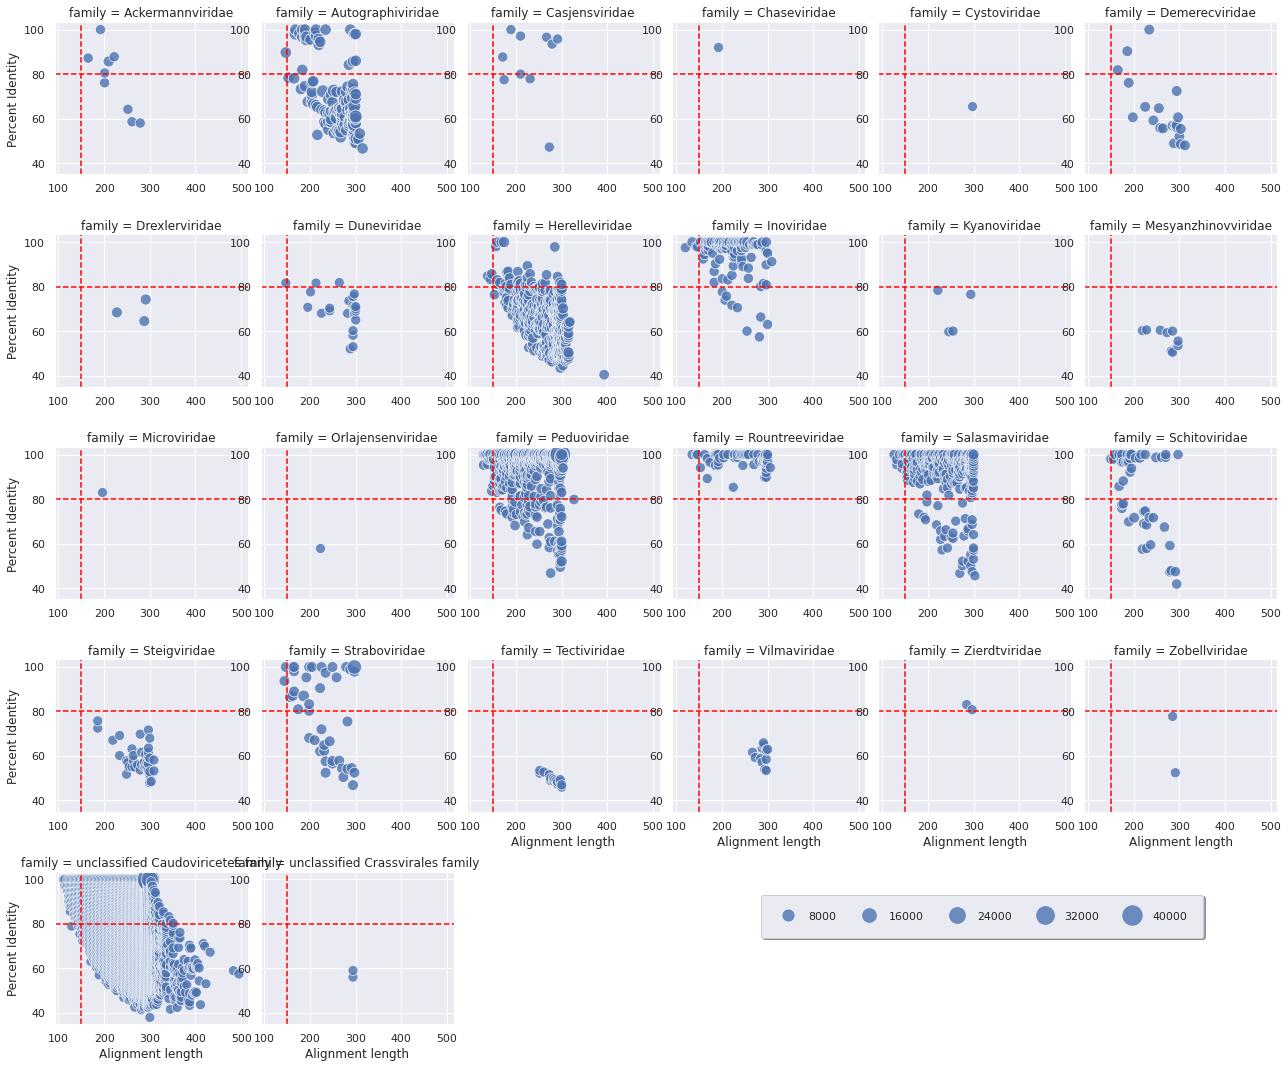

In [41]:
#filter
virusesGroup = bacterial_viruses.groupby(by=['family','alnlen','pident'], as_index=False).count()

#styling
sizeScatter = 10 * virusesGroup['count']
sns.set_style("darkgrid")
sns.set_palette("colorblind")
sns.set(rc={'figure.figsize':(20,10)})

g = sns.FacetGrid(virusesGroup, col="family", col_wrap=6)
g.map_dataframe(sns.scatterplot, "alnlen", "pident", alpha=.8, sizes=(100,500), size=sizeScatter)
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelleft=True, labelbottom=True)
    ax.axhline(y=80, c='red', linestyle='dashed', label="_horizontal")
    ax.axvline(x=150, c='red', linestyle='dashed', label="_vertical")

g.fig.subplots_adjust(hspace=0.4)
g.set_axis_labels("Alignment length", "Percent Identity")
plt.legend(bbox_to_anchor=(5.0,1), loc=0, borderaxespad=2,ncol=6, shadow=True, labelspacing=1.5, borderpad=1.5)
plt.show()

In [43]:
data

,seqID,sampleID,count,percent,alnType,targetID,evalue,pident,fident,nident,...,taxMethod,kingdom,phylum,class,order,family,genus,species,baltimoreType,baltimoreGroup
0,753522_20180606_S:1:8.070e-05:416574,753522_20180606_S,1,0.000081,aa,A0A4D6B1D2,4.006000e-36,95.6,0.956,66,...,LCA,Viruses,Uroviricota,Caudoviricetes,unclassified Caudoviricetes order,unclassified Caudoviricetes family,unclassified Caudoviricetes genus,Streptococcus phage Javan336,NaN,NaN
1,1465461_20180406_S:1:8.858e-05:475829,1465461_20180406_S,1,0.000089,aa,A0A4D5ZJ74,5.922000e-10,40.6,0.406,26,...,TopHit,Viruses,unclassified Viruses phylum,unclassified Viruses class,unclassified Viruses order,unclassified Viruses family,unclassified Viruses genus,Streptococcus satellite phage Javan245,NaN,NaN
2,676138_20180405_S:1:7.596e-05:172466,676138_20180405_S,1,0.000076,aa,A0A4D6ASX5,1.008000e-32,62.6,0.626,57,...,LCA,Viruses,Uroviricota,Caudoviricetes,unclassified Caudoviricetes order,unclassified Caudoviricetes family,unclassified Caudoviricetes genus,unclassified Caudoviricetes species,NaN,NaN
3,770590_20180115_S:3:1.954e-04:54458,770590_20180115_S,3,0.000195,aa,A0A4D6A774,5.977000e-31,62.7,0.627,64,...,TopHit,Viruses,Uroviricota,Caudoviricetes,unclassified Caudoviricetes order,unclassified Caudoviricetes family,unclassified Caudoviricetes genus,Streptococcus phage Javan191,NaN,NaN
4,788707_20180301_S:3:3.141e-03:32498,788707_20180301_S,3,0.003141,aa,A0A4D5ZJV0,2.863000e-16,88.8,0.888,40,...,TopHit,Viruses,unclassified Viruses phylum,unclassified Viruses class,unclassified Viruses order,unclassified Viruses family,unclassified Viruses genus,Streptococcus satellite phage Javan313,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360634,1565754_20171128_S:5:1.491e-03:124466,1565754_20171128_S,5,0.001491,nt,tid|1916174|KY065475.1,6.165000e-69,93.3,0.933,0,...,TopHit,Viruses,Uroviricota,Caudoviricetes,unclassified Caudoviricetes order,unclassified Caudoviricetes family,unclassified Caudoviricetes genus,Streptococcus phage IPP35,NaN,NaN
360635,715927_20180205_S:1:2.016e-04:228569,715927_20180205_S,1,0.000202,nt,tid|340016|KX814294.1,2.134000e-40,74.3,0.743,0,...,TopHit,Viruses,unclassified Viruses phylum,unclassified Viruses class,unclassified Viruses order,unclassified Viruses family,unclassified Viruses genus,uncultured virus,NaN,NaN
360636,715927_20180205_S:1:2.016e-04:230486,715927_20180205_S,1,0.000202,nt,tid|340016|KX814294.1,1.352000e-73,83.7,0.837,0,...,TopHit,Viruses,unclassified Viruses phylum,unclassified Viruses class,unclassified Viruses order,unclassified Viruses family,unclassified Viruses genus,uncultured virus,NaN,NaN
360637,892355_20180123_S:3:2.246e-03:39818,892355_20180123_S,3,0.002246,nt,tid|360398|AB243556.1,5.740000e-39,92.9,0.929,0,...,TopHit,Viruses,Uroviricota,Caudoviricetes,unclassified Caudoviricetes order,unclassified Caudoviricetes family,Peeveelvirus,Peeveelvirus PVL108,NaN,NaN
